Notebook developped by Bastien Trotobas, adapted by Clément Trotobas

## File selection

In [18]:
# Imports
import ipywidgets as widgets
import numpy as np
import pandas as pd
from collections import defaultdict
import re

# Write in value the path to the spreadsheet
file_path = widgets.Text(value='./Trotobas_Upper-Limb_Exoskeletons_Orthotics_and_Prosthetics_featured_in_ ASME_JMR.xlsx', description='Data file')

## Data filter

In [19]:
dataPanda = pd.read_excel (file_path.value)
data = np.array(dataPanda)
nb_lvls = 4  # Number of level of categorization
data_start = 5  # The column index where the data starts

# Change the string to True/False
data[data == 'n'] = False
data[data == 'x'] = False
data[data == 'y'] = True

# Fill the NaN with the previous value in categories
data[0, :nb_lvls][pd.isna(data[0, :nb_lvls])] = ''
for idx in range(1, len(data)):
    mask = pd.isna(data[idx, :4])
    data[idx, :nb_lvls][mask] = data[idx-1, :nb_lvls][mask]

# Generate the features and getters
features = ['_'.join(feature_row) for feature_row in data[:, :nb_lvls]]
getters = {feature: lambda d, idx=idx: str(d[idx]) for idx, feature in enumerate(features)}

# Post-fix the getters that should return number (and not string)
features_number = ('meta data___year', 'meta data___number of actuator')
for feature in features_number:
    idx = features.index(feature)
    getters[feature] = lambda d, idx=idx: d[idx]

# Clasify the features in categories
categories = [{d[0] for d in data}] + [defaultdict(set) for _ in range(1, nb_lvls)]
for d in data:
    for lvl in range(1, nb_lvls):
        categories[lvl]['_'.join(d[:lvl])].add(d[lvl])

        
########### FROM HERE, WE ASSUME nb_lvl = 4 ###########
        # could be factorized with functions #
    
# LEVEL 4 --- Build a selector per feature
selectors = {feature: widgets.SelectMultiple(options=sorted({getters[feature](d) for d in data[:, data_start:].T}),
                                             description=re.search(r'([^_]+)$', feature)[0], #gets characters before
                                                                                     # '_' starting from the end
                                             style = {'description_width': 'initial'},
                                             value=sorted({getters[feature](d) for d in data[:, data_start:].T}))
            for feature in features}

# LEVEL 3 --- Build a HBOX per level 3 category
hboxes = {}
for category, these_features in categories[3].items():
    children = [selectors[category + '_' + feature] for feature in these_features]
    hboxes[category] = widgets.HBox(children)
    
# LEVEL 2 --- Build an accordion per level 2 category
accordions = {}
for category, these_features in categories[2].items():
    children = [hboxes[category + '_' + feature] for feature in these_features]
    accordions[category] = widgets.Accordion(children)
    for idx, feature in enumerate(these_features):
        accordions[category].set_title(idx, feature)
    
# LEVEL 1 --- Build a tab per level 1 category
tabs = {}
for category, these_features in categories[1].items():
    children = [accordions[category + '_' + feature] for feature in these_features]
    tabs[category] = widgets.Tab(children)
    for idx, feature in enumerate(these_features):
        if feature == '':
            feature = 'meta data'
        tabs[category].set_title(idx, feature)

        
# Display the result
main_frame = widgets.Tab(tuple(tabs.values()))
for idx, feature in enumerate(('meta data', 'movements', 'signal', 'energy', 'mechanical')):
    main_frame.set_title(idx, feature)
main_frame

## Data plot

In [4]:
# To choose whether the figures are displayed in the console or in a new window
#%matplotlib
%matplotlib inline


C:\Users\ctrotoba.AD\AppData\Local\Temp/ipykernel_5292/528264171.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


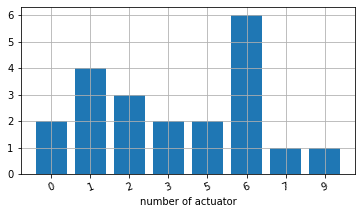

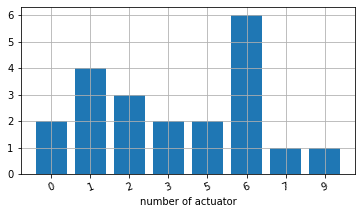

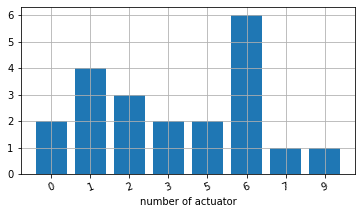

C:\Users\ctrotoba.AD\AppData\Local\Temp/ipykernel_5292/528264171.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


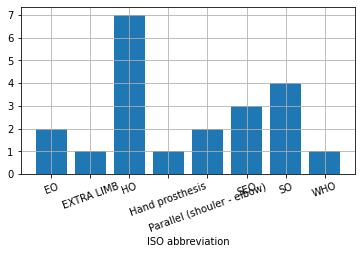

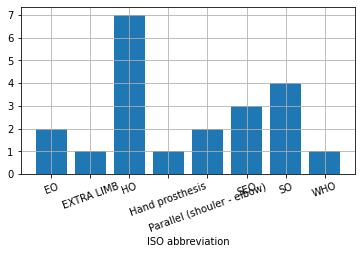

KeyError: None

In [5]:
import matplotlib.pyplot as plt

#Build plot functions
def plot_histo(filtered_data,data,description_DataType):
    dataType = descript_to_feature(description_DataType)
    allSelectedData = [getters[dataType](col) for col in filtered_data]
    fig = plt.figure()
    histograme = defaultdict(int)
    for d in filtered_data:
        histograme[getters[dataType](d)] += 1
    xHisto = sorted(histograme)
    plt.bar(range(len(histograme)), [histograme[key] for key in xHisto], align='center')
    plt.xticks(range(len(histograme)), xHisto)
    plt.xlabel(description_DataType)
    plt.xticks(rotation='20')
    fig.subplots_adjust(bottom=0.3)
    return fig

def plot_versus(data,description_DataType1,description_DataType2):
    dataType1 = descript_to_feature(description_DataType1)
    dataType2 = descript_to_feature(description_DataType2)
    fig = plt.figure()
    for d in data:
        plt.scatter(getters[dataType1](d), getters[dataType2](d), marker = 'x',c = 'blue')
    #plt.plot([0.0, 10.0], [0.0, 10.0], 'r-', lw=2) # first bisector
    plt.xlabel(description_DataType1)
    plt.ylabel(description_DataType2)
    plt.xticks(rotation='20') 
    return fig


def update_plot(change):
    # Get the filtered data
    filtered_data = [d for d in data[:, data_start:].T
                     if all(getters[feature](d) in selectors[feature].value for feature in features)]
    if plot_type.value == 'None':
        pass
    else:
        if plot_type.value == 'Histogram':
            fig = plot_histo(filtered_data,data[:,data_start:].T,feature_one.value)
        elif plot_type.value == 'Versus':
            fig = plot_versus(filtered_data,feature_one.value,feature_two.value)
        fig.patch.set_facecolor('white')
        plt.grid(True)
        fig.show()
        #fig.savefig('myFig.pdf')
    
           
# Get the feature associated to the description (for buttons) 
def descript_to_feature(description):
    for feature in features:
        if description == re.search(r'([^_]+)$', feature)[0]:
            return feature
        
        
# Buttons
plot_type = widgets.ToggleButtons(options=('None','Histogram', 'Versus'), description='Plot type')

opt=('None','year','number of actuator','ISO abbreviation','pneumatic pressure','cable','name',
     'portable','fixed','multiple joint','(u) across joints','(u) across fingers','(c) across joints',
     '(c) across fingers', 'application', 'bowden cable','reported function','polycentric','monocentric','battery') # <- Write here 
        # the desired features

feature_one = widgets.ToggleButtons(options=opt, description='Feature 1')
feature_two = widgets.ToggleButtons(options=opt, description='Feature 2')


# Update plot when something change
plot_type.observe(update_plot)
# Display widgets
widgets.VBox((feature_one,feature_two,plot_type))

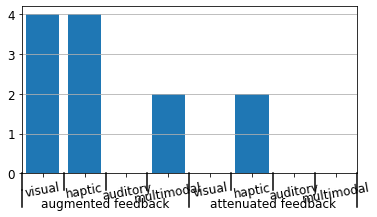

In [6]:
########### credit to Trenton McKinney for the functions  
#(https://stackoverflow.com/questions/19184484/how-to-add-group-labels-for-bar-charts-in-matplotlib)

from matplotlib import pyplot as plt

###
plt.rcParams.update({'font.size': 12})
###

def mk_groups(data):
    try:
        newdata = data.items()
    except:
        return

    thisgroup = []
    groups = []
    for key, value in newdata:
        newgroups = mk_groups(value)
        if newgroups is None:
            thisgroup.append((key, value))
        else:
            thisgroup.append((key, len(newgroups[-1])))
            if groups:
                groups = [g + n for n, g in zip(newgroups, groups)]
            else:
                groups = newgroups
    return [thisgroup] + groups

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_group_bar(ax, data):
    groups = mk_groups(data)
    xy = groups.pop()
    x, y = zip(*xy)
    ly = len(y)
    xticks = range(1, ly + 1)

    ax.bar(xticks, y, align='center')
    ax.set_xticks(xticks)
    ax.set_xticklabels(x)
    ax.set_xlim(.5, ly + .5)
    ax.yaxis.grid(True)
    
    ###
    plt.xticks(rotation='10') 
    ###
    
    scale = 1. / ly
    for pos in range(ly + 1):
        add_line(ax, pos * scale, -.1)
    ypos = -.2
    while groups:
        group = groups.pop()
        pos = 0
        for label, rpos in group:
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos * scale, ypos)
            pos += rpos
        add_line(ax, pos * scale, ypos)
        ypos -= .1
        
###########     
        
# Get the filtered data      
filtered_data = [d for d in data[:, data_start:].T
                     if all(getters[feature](d) in selectors[feature].value for feature in features)]

def number_true_feature(d, feature):
    return sum([getters[feature](d) == 'True' for d in filtered_data])

    # could be more elegant #
nb_article_criteria = {category0: {category1: {category2 : {category3: number_true_feature(d, '_'.join((category0, category1, category2, category3)))
                                                           for category3 in categories[3]['_'.join((category0, category1, category2))]}
                                              for category2 in categories[2]['_'.join((category0, category1))]}
                                   for category1 in categories[1][category0]}
                       for category0 in categories[0]}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
label_group_bar(ax, nb_article_criteria['signal']['user feedback']) # <- Write here the categories
fig.subplots_adjust(bottom=0.3)